### Group 118   Feng Lin   s3522722

# Predicting survival of heart failure patients





## Introduction

Heart failure is a chronic condition in which the heart does not pump enough blood to supply the body. In this project, we use the Heart failure clinical records Data sourced from the UCI Machine Learning Repository(Davide Chicco, Giuseppe Jurman. 2020) to predict the survival of an individual patient with heart failure during the follow-up period within an acceptable margin of error. This report is organized as follows:
- [Overview](#ov) : introducing the data, report structure and methodology using in this report
- [Data Import and Transformation](#dp) : importing and scaling data
- [Predictive Modelling](#pm) : feature selections, hypermeters tuning, model building and comparison
- [Limitation](#lmt) : limitation of the report
- [Summary](#sm) : providing summary of the phase 1 and phase 2
- [References](#re)

## Overview <a id='ov'></a>

### Dataset Details

The dataset is about medical records of heart failure patients who were admitted to Institute of Cardiology and Allied hospital Faisalabad-Pakistan between April and December in 2015. The records include individual medical history and pathology results. The dataset has 13 features and 299 observations.  Our target feature is "death event", which refers to "if the patient deceased during the follow-up period". Since the target feature is boolean, our project is on a classification problem.

### Report Overview

In Phase 1, we have preprocessed and transformed the dataset which is now ready for modelling. We also explored different sets of descriptive features and discussed three of them that would have high importance in the prediction. In this Phase 2 report, we will quickly get the data ready and start modelling with feature selection, then we use three algorithms to fit the data and finish with model comparison. Lastly, we will discuss the limitations and the preference of our model selection in the context of the data. Summary of the whole report will also be given. 

### Methodology

Since this project is a classification problem and the target feature is binary, we will use three binary classifiers to predict the target feature: 

- K-Nearest Neighbors (KNN),
- Naive Bayes (NB), and
- Decision trees (DT).

After Phase 1 data preprocessing, we will firstly use the powerful Random Forest Importance method inside a pipeline to overview the feature importances. Based on the rankings and importance results, we will set a possible range of feature numbers to model fitting. Then we will define a single pipeline combining feature selections and hyperparameters tuning and perform a 5-fold stratified cross-validation with 3 repeats to each classifier method. We also use parallel processing which is using "-2" cores in each model fitting. After obtaining the best estimator for each model, we will list the top models as well as visualise the search for the best hypermeters. Models comparison will follow once all the three models have been identified. Each best model of the classifier will be tested on the test set. We will compare the cross-validation scores. Moreover, accuracy, precision, recall, F1 score and confusion matrix metrics will be built and used to determine the final best model from the three. 



## Data Import and Transformation<a id='dp'></a>

### Importing dataset

We import the data and separate the descriptive features and target feature. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

np.random.seed(999)

In [2]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
Data = data.drop(columns = 'DEATH_EVENT')
target = data['DEATH_EVENT']

### Scaling of Features

We have already checked the missing values and any abnormality in Phase 1. This dataset is clean and encoded. We can just perform Min-Max scaling method to numerical descriptive features. 

In [3]:
from sklearn import preprocessing

Data_df = Data.copy()

Data_scaler = preprocessing.MinMaxScaler()
Data = Data_scaler.fit_transform(Data)
Data = pd.DataFrame(Data, columns=Data_df.columns)

Data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,0.636364,0.0,0.071319,0.0,0.090909,1.0,0.290823,0.157303,0.485714,1.0,0.0,0.000000
1,0.272727,0.0,1.000000,0.0,0.363636,0.0,0.288833,0.067416,0.657143,1.0,0.0,0.007117
2,0.454545,0.0,0.015693,0.0,0.090909,0.0,0.165960,0.089888,0.457143,1.0,1.0,0.010676
3,0.181818,1.0,0.011227,0.0,0.090909,0.0,0.224148,0.157303,0.685714,1.0,0.0,0.010676
4,0.454545,1.0,0.017479,1.0,0.090909,0.0,0.365984,0.247191,0.085714,0.0,0.0,0.014235


Now, we can start modelling.

## Predictive Modelling<a id='pm'></a>

### Feature Ranking

Before model fitting, as of a fairly small number of features which is 12, we are going to have a general idea about the ranking of all features using Random Forest Importance (RFI) in the full dataset. We will visualise the importances of all the features. In the hyperparameter tuning sections, we will include feature selection and determine which number of features is the best for each classifier. 

In [4]:
from sklearn.ensemble import RandomForestClassifier

model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1]

best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['time', 'serum_creatinine', 'ejection_fraction', 'age',
       'platelets', 'creatinine_phosphokinase', 'serum_sodium', 'sex',
       'high_blood_pressure', 'anaemia', 'smoking', 'diabetes'],
      dtype=object)

In [5]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.37029907, 0.13518977, 0.11614812, 0.09407499, 0.07957403,
       0.07460812, 0.07110006, 0.0157957 , 0.01212956, 0.01113133,
       0.01095219, 0.00899708])

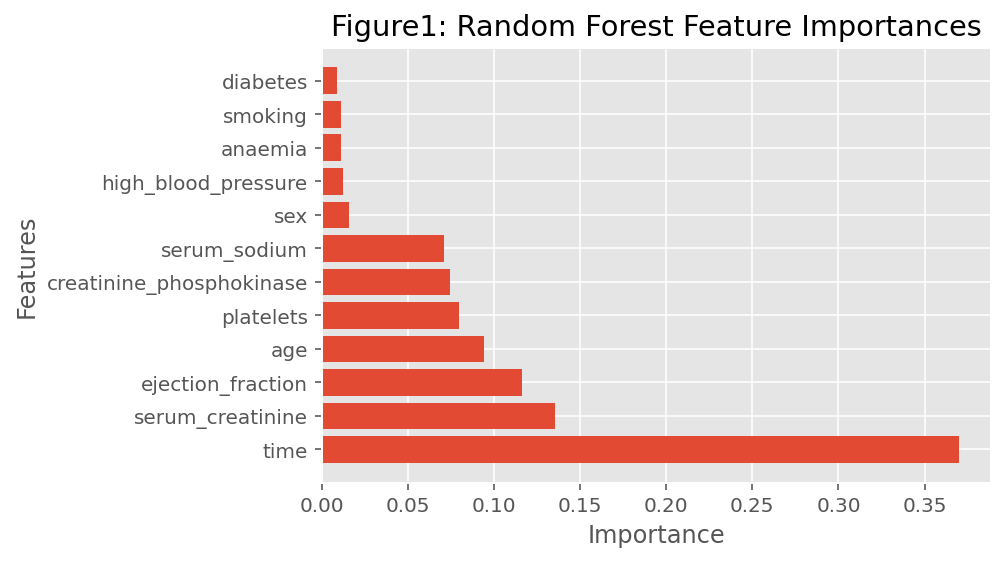

In [6]:
plt.barh(best_features_rfi, feature_importances_rfi)
plt.title('Figure1: Random Forest Feature Importances')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

Figure 1 shows the most important feature is actually "time". Two other features (ejection_fraction and serum_creatinine) which we have also identified in phase 1 are following time. Surprisingly, anaemia is the less important one using this method, while in Phase 1 we suspected it would be more of importance. 
Based on figure 1, though time is the most important, using only time would be pointless. So we start from 2 and up to 7, which is the number of features having higher importance scores. Also, we will include the full set. Therefore, We will search over 2 to 7 and 12 features for each classifier. 

### Data Train-Test Splitting

The dataset has 299 observations which is not a big number, so we will use the whole dataset. We split the data into train and test partitions with a 70:30 ratio using stratification. 

In [7]:
from sklearn.model_selection import train_test_split

D_train, D_test, t_train, t_test = train_test_split(Data.values, 
                                                    target.values, 
                                                    test_size=0.3, 
                                                    random_state=999,
                                                    stratify = target)
print(D_train.shape)
print(D_test.shape)

(209, 12)
(90, 12)


### Model Evaluation Strategy

Now, we have 209 rows for training and 90 rows for later testing. For each model, we will use 5-fold stratified cross-validation evaluation method with 3 repetitions for hyperparameter tuning. 

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

### Model Fitting and Tuning

#### K-Nearest Neighbors (KNN)

To determine the KNN hyperparameters, we will try 1, 5, 10, 15, 20 neighbors and both Manhattan and Euclidean distance. Also, as mention before, we will search number of features from 2 to 7 and 12. 

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100, random_state=999)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [2,3,4,5,6,7,12],
                   'knn__n_neighbors': [1, 5, 10, 15, 20],
                   'knn__p': [1, 2]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='roc_auc',
                           verbose=1) 

In [11]:
gs_pipe_KNN.fit(D_train,t_train)

Fitting 15 folds for each of 70 candidates, totalling 1050 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-2)]: Done 1050 out of 1050 | elapsed:   57.9s finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=Pipeline(steps=[('rfi_fs', RFIFeatureSelector()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-2,
             param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20],
                         'knn__p': [1, 2],
                         'rfi_fs__n_features_': [2, 3, 4, 5, 6, 7, 12]},
             scoring='roc_auc', verbose=1)

In [12]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 20, 'knn__p': 1, 'rfi_fs__n_features_': 5}

In [13]:
gs_pipe_KNN.best_score_

0.8910890218156229

The best KNN model has a mean AUC score of 0.891, with 5 selected features and 20 nearest neighbors and using Manhattan distance(p=1). Though we have the result for the best model, we will still have a look at the other possible models. 

In [14]:
def get_search_results(gs):
    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})
    models = []
    scores = []
    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))
    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))
    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)
    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]
    return pipe_results[columns]

In [15]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
59,0.891089,0.023824,0.934949,0.849490,20.0,1.0,5.0
58,0.890161,0.023975,0.931122,0.852785,20.0,1.0,4.0
44,0.887505,0.026614,0.938776,0.838196,15.0,1.0,4.0
65,0.887352,0.033351,0.945153,0.840849,20.0,2.0,4.0
30,0.886725,0.033237,0.951531,0.832418,10.0,1.0,4.0


So we can see that the top 5 models are having very little different. We will visualise the performance of different hyperparameters when feature number is 5.

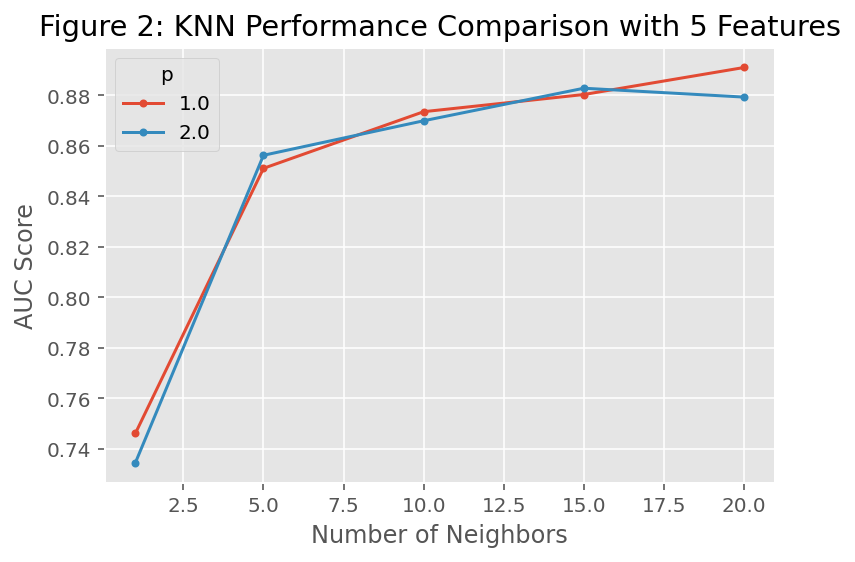

In [16]:
results_KNN_5_features = results_KNN[results_KNN['rfi_fs__n_features_'] == 5].sort_values('knn__n_neighbors')

for i in results_KNN_5_features['knn__p'].unique():
    temp = results_KNN_5_features[results_KNN_5_features['knn__p'] == i]
    plt.plot(temp['knn__n_neighbors'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "p")
plt.xlabel('Number of Neighbors')
plt.ylabel("AUC Score")
plt.title("Figure 2: KNN Performance Comparison with 5 Features")
plt.show()

### (Gaussian) Naive Bayes (NB)

We will fit a Gaussian Naive Bayes model. First of all, we have to perform a power transformation before fitting due to the normality requirement. 

In [17]:
from sklearn.preprocessing import PowerTransformer
D_train_transformed = PowerTransformer().fit_transform(D_train)

Then, the same with the KNN modelling, we test the numbers of features from 2 to 7 and 12. For the hypermeter in NB model, var_smoothing, we start with 10 and end with $10^{-3}$ with 200 different values. But we will randomly pick 75 values to try. 

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [2,3,4,5,6,7,12],
                  'nb__var_smoothing': np.logspace(1,-3, num=200)}

gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          n_iter=75,
                          random_state=999,
                          verbose=1) 

gs_pipe_NB.fit(D_train_transformed, t_train)

Fitting 15 folds for each of 75 candidates, totalling 1125 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-2)]: Done 1125 out of 1125 | elapsed:  1.0min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
                   estimator=Pipeline(steps=[('rfi_fs', RFIFeatureSelector()),
                                             ('nb', GaussianNB())]),
                   n_iter=75, n_jobs=-2,
                   param_distributions={'nb__var_smoothing': array([1.00000000e+01, 9.54771611e+00, 9.11588830e+00, 8.70359136e+00,
       8.30994195e+00, 7.93409667e+00, 7.57525026e+00, 7.23263390...
       2.40940356e-03, 2.30043012e-03, 2.19638537e-03, 2.09704640e-03,
       2.00220037e-03, 1.91164408e-03, 1.82518349e-03, 1.74263339e-03,
       1.66381689e-03, 1.58856513e-03, 1.51671689e-03, 1.44811823e-03,
       1.38262217e-03, 1.32008840e-03, 1.26038293e-03, 1.20337784e-03,
       1.14895100e-03, 1.09698580e-03, 1.04737090e-03, 1.00000000e-03]),
                                        'rfi_fs__n_features_': [2, 3, 4, 5, 6,
                                                                7, 12]},
           

In [19]:
gs_pipe_NB.best_params_

{'rfi_fs__n_features_': 4, 'nb__var_smoothing': 0.0644236350872137}

In [20]:
gs_pipe_NB.best_score_

0.8895496129486277

The best fit NB model is when 'nb__var_smoothing' is 0.0644 with 4 features, and AUC score is 0.8895 which is very close to KNN method result. We can not conclude which one is better at this stage and will perform a paired t-test later. Again, we will show the top 5 models and visualise the search with 4 features. 

In [21]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head()

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
24,0.889550,0.039044,0.961735,0.829082,4.0,0.035297
19,0.889550,0.039255,0.964286,0.829082,4.0,0.064424
51,0.888673,0.039097,0.959184,0.826531,4.0,0.007663
39,0.888673,0.039097,0.959184,0.826531,4.0,0.007317
28,0.888673,0.039097,0.959184,0.826531,4.0,0.006986


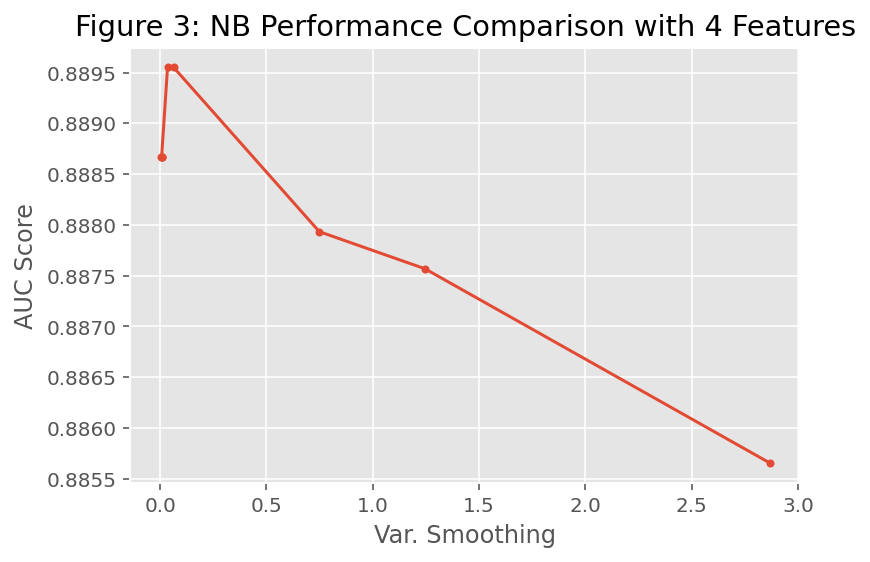

In [22]:
results_NB_4_features = results_NB[results_NB['rfi_fs__n_features_'] == 4.0].sort_values('nb__var_smoothing')

plt.plot(results_NB_4_features['nb__var_smoothing'], results_NB_4_features['mean_score'], marker = '.', label = i)    
plt.xlabel('Var. Smoothing')
plt.ylabel("AUC Score")
plt.title("Figure 3: NB Performance Comparison with 4 Features")
plt.show()

### Decision Trees (DT)

For Decision Tree, we will use gini index to maximize the information gain. Since we have had relatively low number for selected features with both NB and KNN classifiers, in the Decision Tree classifier, we are going to include feature number up to 6 only. Therefore, we can include more numbers in maximum depth and minimum sample split. For maximum depth, we choose 3, 5, 6, 10 and for minimum sample split, we go with 5, 15 ,30, 50. 

In [23]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=111))])

params_pipe_DT = {'rfi_fs__n_features_': [2,3,4,5,6],
                  'dt__max_depth': [3, 5, 6, 10],
                  'dt__min_samples_split': [ 5, 15 ,30, 50]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT.fit(D_train, t_train)

Fitting 15 folds for each of 80 candidates, totalling 1200 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-2)]: Done 1200 out of 1200 | elapsed:  1.2min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=Pipeline(steps=[('rfi_fs', RFIFeatureSelector()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=111))]),
             n_jobs=-2,
             param_grid={'dt__max_depth': [3, 5, 6, 10],
                         'dt__min_samples_split': [5, 15, 30, 50],
                         'rfi_fs__n_features_': [2, 3, 4, 5, 6]},
             scoring='roc_auc', verbose=1)

In [24]:
gs_pipe_DT.best_params_

{'dt__max_depth': 10, 'dt__min_samples_split': 30, 'rfi_fs__n_features_': 4}

In [25]:
gs_pipe_DT.best_score_

0.8690203269636768

The best DT has 4 selected features, the maximum depth of 10 and minimum split value of 30 with an AUC score of 0.869. We can see that the AUC score is low than KNN and NB methods. Again, let us have a look at top 5 DT and visualise the searching when feature number is 4. 

In [26]:
results_DT = get_search_results(gs_pipe_DT)
results_DT.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
72,0.869020,0.037747,0.936340,0.803571,10.0,30.0,4.0
52,0.867020,0.038924,0.936340,0.803571,6.0,30.0,4.0
73,0.865725,0.043801,0.933673,0.766578,10.0,30.0,5.0
77,0.863325,0.046283,0.941327,0.759615,10.0,50.0,4.0
57,0.861750,0.047246,0.941327,0.759615,6.0,50.0,4.0


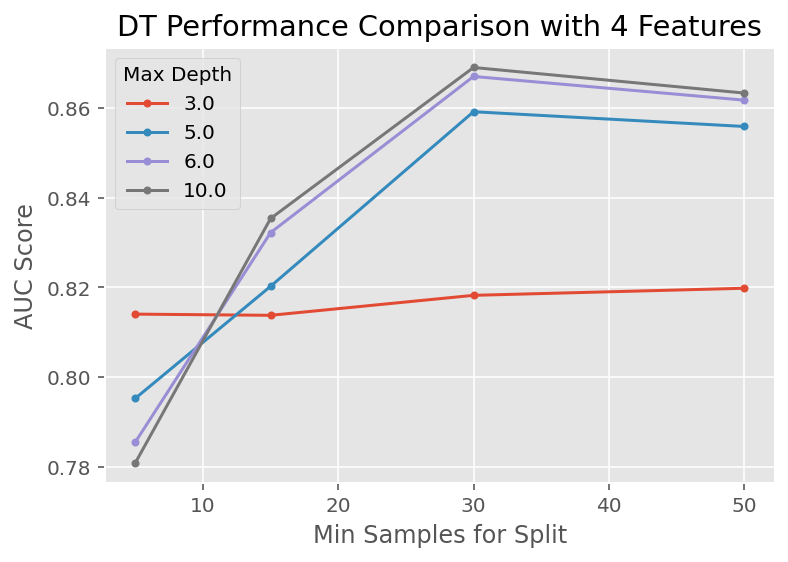

In [27]:
results_DT_4_features = results_DT[results_DT['rfi_fs__n_features_'] == 4].sort_values('dt__min_samples_split')


for i in results_DT_4_features['dt__max_depth'].unique():
    temp = results_DT_4_features[results_DT_4_features['dt__max_depth'] == i]
    plt.plot(temp['dt__min_samples_split'], temp['mean_score'], marker = '.', label = i)
    
plt.legend(title = "Max Depth")
plt.xlabel('Min Samples for Split')
plt.ylabel("AUC Score")
plt.title("DT Performance Comparison with 4 Features")
plt.show()

### Model comparison

Now, we have determined the best hyperparameter values for each of the three classifiers. For KNN, we have $k = 20$ and $p = 1$ with 5 selected features. For NB, we have nb__var_smoothing = 0.0644 with 4 selected features. For DT, we have 4 selected features, the maximum depth of 10 and minimum split value of 30. We will use the test set to test these three models. The test data has 90 observations. Firstly, we will use fixed random seed and run 3-fold stratified cross-validation with 3 repeats.

In [28]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=666)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=D_test,
                                 y=t_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.8840005878894768

In [29]:
D_test_transformed = PowerTransformer().fit_transform(D_test)

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=D_test_transformed,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_NB.mean()

0.8848177542621988

In [30]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                X=D_test,
                                y=t_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT.mean()

0.8521781305114637

The results for NB and KNN are very close, while the result for DT is obviously lower than the other two. Now, we will perform a paired t-test to each pair to find out their differences in performance. 

In [31]:
from scipy import stats

print(stats.ttest_rel(cv_results_KNN, cv_results_NB))
print(stats.ttest_rel(cv_results_DT, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

Ttest_relResult(statistic=-0.10147543239413558, pvalue=0.9216703040801878)
Ttest_relResult(statistic=-3.404541826311776, pvalue=0.00929783063211257)
Ttest_relResult(statistic=-3.4159447933477787, pvalue=0.00914251526318942)


The t-test results confirm there is a statistically significant difference between DT and KNN, and also between DT and NB. Performances for KNN and NB have no difference. Therefore, based on the comparisons of AUC, we can choose either NB or KNN as our best model. 
The next step, we can consider the context of the data to see if we can weight those two models into one better than another. 
To achieve that, we will bring the following metrics to evaluate models using the test set. 
- Accuracy
- Precision
- Recall
- F1 Score (the harmonic average of precision and recall)
- Confusion Matrix

In [32]:
pred_KNN = gs_pipe_KNN.predict(D_test)
pred_NB = gs_pipe_NB.predict(D_test_transformed)
pred_DT = gs_pipe_DT.predict(D_test)

In [33]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(t_test, pred_KNN))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(t_test, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(t_test, pred_DT))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        61
           1       0.82      0.62      0.71        29

    accuracy                           0.83        90
   macro avg       0.83      0.78      0.79        90
weighted avg       0.83      0.83      0.83        90


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        61
           1       0.75      0.72      0.74        29

    accuracy                           0.83        90
   macro avg       0.81      0.80      0.81        90
weighted avg       0.83      0.83      0.83        90


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        61
           1       0.78      0.72      0.75        29

    accuracy                           0.84        90
  

In [34]:
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(t_test, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(t_test, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(t_test, pred_DT))


Confusion matrix for K-Nearest Neighbor
[[57  4]
 [11 18]]

Confusion matrix for Naive Bayes
[[54  7]
 [ 8 21]]

Confusion matrix for Decision Tree
[[55  6]
 [ 8 21]]


Our goal is to predict the survival of a patient within the follow-up period. In this context, it would be more important to detect as many patients who will not survive as possible. Therefore, we will look into the positive recall values for the three models. NB and DT are the same, 0.72 higher than KNN. And considering previously, we based on AUC and determine either NB or KNN as our best model. The best model for this dataset is NB. 

## Limitations<a id='lmt'></a>

Our predictive modelling would have some limitations in this dataset. Firstly, the size of the dataset is still considered as small. With 209 observations for training and 90 for testing, though we used folds and repeats, it would be better if we can have a larger dataset. A possible alternative to overcoming this issue is to use the whole dataset(using cross-validation) for training and for testing (set different seed). Secondly, the most important feature is "time" having the highest correlation with survival. Also, all the three models have pretty promising scores. However, it would be more than just a feature. How is the follow-up time determined? For instance, if a patient has more severe condition, they might normally have a sooner follow-up. But is that sooner enough or not? It could be more complicated. A good idea is to gain more information about how the time is determined by medical professionals. Then we can better understand the time feature and consider possible adjustment to be done.     

## Summary <a id='sm'></a>

In Phase 1, we identified our target and the goal, explored the data through visualisations, and identified some important descriptive features. We finished the data preprocessing and transformation to made the dataset ready for modeling. In Phase 2, we starts by overview of feature importances. Then we split the dataset to training and testing, and use KNN, NB and DT classifiers to fit the data and determine the relevant hyperparameters. Next we compare the best model from each classifiers and find out the best model of the dataset. 
We have found that the best model for this data is using Gaussian Naive Bayes (NB) of hyperparameter 0.0644 with 4 features selected by Random Forest Importance (RFI). This model produces nearly the highest cross-validated AUC score on the training data(only 0.001 less than KNN). Then it has 0.884 cross validation score on the test set and successfully picks up 72% of the non-survival patients, which is also the true positive rate we are more interested in. In general outcome, it has 83% accuracy. 
To sum up, using machine learning to predict the survival of a patient with heart failure is possible and promising. 

## References<a id='re'></a>

- Davide Chicco, Giuseppe Jurman (2020).  UCI Machine Learning Repository (online) Available at http://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records [Accessed 01/04/2021]
- Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5
- Heart Foundation, What is heart failure?, (2021), Link: https://www.heartfoundation.org.au/conditions/heart-failure#:~:text=In%20heart%20failure%20with%20reduced,in%20your%20body's%20blood%20vessels.
- Vural Aksakalli, Zeren Yenice, Yong Kai Wong, Imran Ture, Milad Malekipirbazari (2020). Case Study: Predicting Income Status (online) Available at https://www.featureranking.com/tutorials/machine-learning-tutorials/case-study-predicting-income-status/

